In [1]:
from Voxel_Data_Process import *
import gzip,pickle
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc

from scipy import interp
import matplotlib.pyplot as plt
from Plane_Data_Process import *


# 定义输入的图片尺寸，图片为正方形
pixel_size = 64
function = 'Merge_Resnet_half'

aug_times=1



# 读取实际的y_val的值的函数
def read_y_val(pixel_size, fold):
    (x_train,y_train,x_val,y_val)=k_fold(pixel_size,fold)
    (x_train,y_train,x_val,y_val)=(x_train[:x_train.shape[0]/aug_times],
                                               y_train[:x_train.shape[0]/aug_times],
                                               x_val[:x_val.shape[0]/aug_times],
                                               y_val[:x_val.shape[0]/aug_times])
    #if this is single plane cancel annotation
    (x_train,y_train)=handle_data(x_train,y_train,0,64)
    print (x_train.shape)
    (x_val,y_val)=handle_data(x_val[:x_val.shape[0]/2],y_val[:x_val.shape[0]/2],0,64)

    return y_val

# 测试代码
y_val = read_y_val(pixel_size, 1)
print((y_val.shape))

Loaded configurations from (in order) ['/home/ilab/Jupyter/CNN/config/default.ini']
OpenCV 2 available, using that for augmentation
(353, 64, 64, 64, 1)
Start to split dataset....
Random split dataset success....
Get 9 Planes success...


/home/ilab/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(564, 64, 64, 1)
Get 9 Planes success...
(70, 2)


In [2]:
# 将y_val从[0 1]的双标签转为单标签
def convert_label(y_val):
    
    
    y_val_after = []
    y_val = list(y_val)
    
    for t in y_val:
        t = list(t)       
        if t == [1,0]:
            y_val_after.append(0)
        else:
            y_val_after.append(1)
    
    return (np.array(y_val_after))


def convert_label_pred(y_val_pred):
    # 阈值
    threshold = 0.5
    
    predicted_class = []
    
    for temp in y_val_pred:
        if temp[1] < threshold:
            predicted_class.append(0)
        else:
            predicted_class.append(1)
        
    return (np.array(predicted_class))
    
# 测试代码
# y_val = convert_label(y_val)
# print (y_val)

In [3]:
# 测试代码


# 读取实验预测的y_val_pred的值,画roc时需要将概率转换为0,1标签
def read_y_val_pred(function, ROC):
    
    # 预测的y_val_pred, 0-4对于第几则训练
    y_val_pred = []
    
    # 判断是否含有SVM
    if ('SVM' in function):
        function1 = function[:-7]
        
        for fold in range(1,6):
            with gzip.open('../Learing-CNN/Predict/'+function1+'/'+function+'_Pred_'+str(fold)+'.pkl','rb') as f:
                temp = pickle.load(f)
                if ROC == 0:
                    temp = convert_label_pred(temp)
                y_val_pred.append(temp)
        print ('SVM')
    else:
        for fold in range(1,6):
            with gzip.open('../Learing-CNN/Predict/'+function+'/'+function+'_Pred_'+str(fold)+'.pkl','rb') as f:
                temp = pickle.load(f)
                if ROC == 0:
                    temp = convert_label_pred(temp)
                y_val_pred.append(temp)
        print ('No, SVM')
        
        
    return y_val_pred

y_val_pred=read_y_val_pred(function,0)


No, SVM


In [4]:
# 求 Accuracy, Recall, sensitivity and specificity 
def ARSS(function):
    
    # 下标0-4对于第几则训练，5为平均值
    accuracy = []
    sensitivity = []
    specificity = []
    recall = []
    # 预测的y_val_pred
    y_val_pred = read_y_val_pred(function,0)
    
        
    # 初始化 False Positive Rate和True Positive Rate
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
   
    # 获取实际的y_val
    y_val = []
    for fold in range(1, 6):
        temp = read_y_val(pixel_size, fold)
        temp = convert_label(temp)
        y_val.append(temp)
    
    for fold in range(0, 5): 
        print (y_val[fold].shape, y_val_pred[fold].shape)
        cm1 = confusion_matrix(y_val[fold], y_val_pred[fold])
        total1=sum(sum(cm1))
        
        # 计算recall        
        recall1 = recall_score(y_val[fold], y_val_pred[fold], average='weighted')
        recall.append(recall1)
        #####from confusion matrix calculate accuracy
        accuracy1=float((cm1[0,0]+cm1[1,1]))/float(total1)
        accuracy.append(accuracy1)
         
        sensitivity1 = float(cm1[0,0])/float((cm1[0,0]+cm1[0,1]))
        sensitivity.append(sensitivity1)
        
        specificity1 = float(cm1[1,1])/float((cm1[1,0]+cm1[1,1]))
        specificity.append(specificity1)
        

    # 计算平均值
    accuracy_mean = (accuracy[0]+accuracy[1]+accuracy[2]+accuracy[3]+accuracy[4])/5
    sensitivity_mean = (sensitivity[0]+sensitivity[1]+sensitivity[2]+sensitivity[3]+sensitivity[4])/5
    specificity_mean = (specificity[0]+specificity[1]+specificity[2]+specificity[3]+specificity[4])/5
    recall_mean = (recall[0]+recall[1]+recall[2]+recall[3]+recall[4])/5
    accuracy.append(accuracy_mean)
    sensitivity.append(sensitivity_mean)
    specificity.append(specificity_mean)
    recall.append(recall_mean)
    
    
    print ('======== '+function+' ========')
    print ('Accuracy : '+str(accuracy[5]))
    print ('Sensitivity : '+str(sensitivity[5]))
    print ('Specificity : '+str(specificity[5]))
    print ('Recall : '+str(recall[5]))
    
    
    f = open('/home/ilab/Jupyter/Learing-CNN/Result.txt','a+')
    f.write('======== '+function+' ========')
    f.write('\n')
    f.write('Accuracy : '+str(accuracy[5])+'\n')
    f.write('Sensitivity : '+str(sensitivity[5])+'\n')
    f.write('Specificity : '+str(specificity[5])+'\n')
    f.write('Recall : '+str(recall[5])+'\n')
    f.write('======== '+function+' ========\n')
    
    f.close()
# ARSS(function)

In [18]:
# ARSS('Merge_Resnet_No_Convolution')
# ARSS('Merge_Resnet_conv_2')
# ARSS('Merge_Resnet_conv_3')
# ARSS('Resnet')
# ARSS('CNN')
# ARSS('Vgg16')

# ARSS('Resnet')
ARSS('Merge_Resnet_D34')
# ARSS('Merge_Resnet_D50')

# ARSS('Merge_Resnet_third')
# ARSS('Merge_Resnet_Depth_14')


No, SVM
(353, 64, 64, 64, 1)
Start to split dataset....
Random split dataset success....
Get 9 Planes success...
(564, 64, 64, 1)
Get 9 Planes success...
(353, 64, 64, 64, 1)
Start to split dataset....
Random split dataset success....
Get 9 Planes success...
(564, 64, 64, 1)
Get 9 Planes success...
(353, 64, 64, 64, 1)
Start to split dataset....
Random split dataset success....
Get 9 Planes success...
(564, 64, 64, 1)
Get 9 Planes success...
(353, 64, 64, 64, 1)
Start to split dataset....
Random split dataset success....
Get 9 Planes success...
(564, 64, 64, 1)
Get 9 Planes success...
(353, 64, 64, 64, 1)
Start to split dataset....
Random split dataset success....
Get 9 Planes success...
(564, 64, 64, 1)
Get 9 Planes success...
((70,), (70,))
((70,), (70,))
((70,), (70,))
((70,), (70,))
((70,), (70,))
======== Merge_Resnet_D34 ========
Accuracy : 0.845714285714
Sensitivity : 0.870588235294
Specificity : 0.822222222222
Recall : 0.8457142857142858


In [5]:
y_origin = []
for fold in range(1, 6):
    temp = read_y_val(pixel_size, fold)    
    y_origin.append(temp)

(353, 64, 64, 64, 1)
Start to split dataset....
Random split dataset success....
Get 9 Planes success...
(564, 64, 64, 1)
Get 9 Planes success...
(353, 64, 64, 64, 1)
Start to split dataset....
Random split dataset success....
Get 9 Planes success...
(564, 64, 64, 1)
Get 9 Planes success...
(353, 64, 64, 64, 1)
Start to split dataset....
Random split dataset success....
Get 9 Planes success...
(564, 64, 64, 1)
Get 9 Planes success...
(353, 64, 64, 64, 1)
Start to split dataset....
Random split dataset success....
Get 9 Planes success...
(564, 64, 64, 1)
Get 9 Planes success...
(353, 64, 64, 64, 1)
Start to split dataset....
Random split dataset success....
Get 9 Planes success...
(564, 64, 64, 1)
Get 9 Planes success...


In [6]:
def draw_ROC(function, line_color,pic_name):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    y_pred = read_y_val_pred(function, 1)    
    for fold in range(0, 5):
        fpr, tpr, thresholds = roc_curve(y_origin[fold].ravel(), y_pred[fold].ravel())
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        
    # 计算fpr, tpr平均值
    mean_tpr /= 5
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, linestyle='--',
        label=pic_name+' (AUC = %0.3f)' % mean_auc,lw=2,color=line_color)
    f = open('/home/ilab/Jupyter/Learing-CNN/Result.txt','a+')
    f.write('======== '+function+' ========\n')
    f.write(''+function+'_AUC : '+str(mean_auc)+'\n')
    f.write('======== '+function+' ========\n')
    f.close()
    print ('Draw ROC over...')


No, SVM
Draw ROC over...
No, SVM
Draw ROC over...
No, SVM
Draw ROC over...
No, SVM
Draw ROC over...


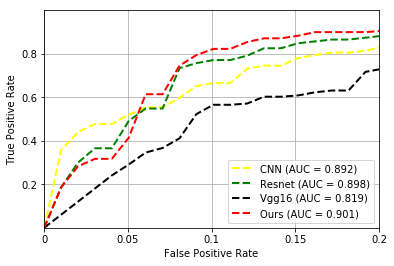

In [12]:
#state-of-art
draw_ROC('CNN','yellow','CNN')
draw_ROC('Resnet','green','Resnet')
draw_ROC('Vgg16','black','Vgg16')
draw_ROC('Merge_Resnet','red','Ours')
# draw_ROC('Merge_Resnet_Depth_14','orange','14')
# draw_ROC('Merge_Resnet_5_Conv','blue','Add 28 Convolution')
# draw_ROC('Merge_Resnet_5_Conv1','grey','7,14,28,64 Convolution')





# draw_ROC('Merge_Resnet','red','Merge_Resnet_conv_4')
# draw_ROC('Merge_Resnet_conv_2','black','Merge_Resnet_conv_2')
# draw_ROC('Merge_Resnet_conv_3','green','Merge_Resnet_conv_3')
# draw_ROC('Merge_Resnet_no_fusion','blue','Merge_Resnet_no_fusion')


# draw_ROC('Merge_Resnet','red','Fusion strategy:add')
# draw_ROC('Merge_Resnet_average','green','Fusion strategy:average')
# draw_ROC('Merge_Resnet_concatenate','black','Fusion strategy:concatenate')
# draw_ROC('Merge_Resnet_no_fusion','blue','Fusion strategy:no fusion')
# draw_ROC('Merge_Resnet_third','yellow','Merge_Resnet_third')



from matplotlib.ticker import FormatStrFormatter
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))

lw = 2
# 画ROC曲线
plt.grid(True)
# plt.plot([0,0.5],[0,1], linestyle='--',color='black')

xlim=np.arange(0,0.3,0.05)
ylim=np.arange(0.2,1,0.2)

# plt.xticks.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(xlim)
plt.yticks(ylim)

plt.xlim([0,0.2])
plt.ylim([0,1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
# plt.savefig('/home/ilab/Jupyter/Learing-CNN/Image/Merge_Resnet_Fusion.png',figsize=(50, 50), dpi=400)
plt.savefig('/home/ilab/Jupyter/Learing-CNN/Image/State_Of_Art.png',figsize=(50, 50), dpi=400)

plt.show()

# Draw The Bar Graph

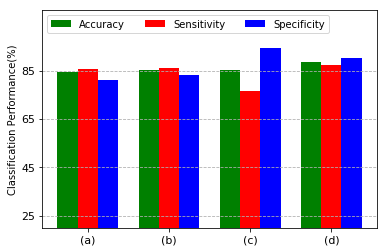

In [7]:
import matplotlib.pyplot as plt
import numpy as np

num=4

x = np.arange(num)

# money = [81, 85, 83, 87,84]

# different convolutions
# auc = [90.1, 89.8, 88.7, 88.8,89.1]

# accuracy = [84.4, 84.1, 86.2, 82.7,87.6,86.7]
# sensitivity = [89.4, 91.1, 87.1, 88.2,94.1,92.2]
# specificity = [80, 76.7, 82.2, 76.7,79.4,83.1]


accuracy = [84.3,85.3, 85.4, 88.6]
sensitivity = [85.7,86.1, 76.5, 87.3]
specificity = [81.1,83.1, 94.4, 90.3]


# # #state-of-art
# accuracy = [ 87.0, 87.7, 87.9,88.3]
# sensitivity = [76.9, 82.1, 78.6, 86.3]
# specificity = [ 90.8, 91.1, 92.2, 90.3]


colors=['#FF0000']*num
colors_x=['#008000']*num
colors_y=['#0000FF']*num






# colors=['blue']*num
# colors_x=['gold']*num
# colors_y=['purple']*num


# colors=['#0000FF']*num
# colors_x=['#FFA500']*num
# colors_y=['#008000']*num




# colors = ['#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000']
# colors_x = ['#00FF00', '#00FF00', '#00FF00', '#00FF00', '#00FF00']
# colors_y = ['#0000FF', '#0000FF','#0000FF', '#0000FF', '#0000FF']

fig, ax = plt.subplots()
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.title('Effectiveness Of Fusing Avg-Pooling layer and Residual Block',fontsize=10,y=1.05)


ax.set_ylim(20,110)
plt.yticks([25,45,65,85],fontsize=11)
# plt.ylabel('Classification Accuracy(%)',y=0.5)
plt.ylabel('Classification Performance(%)',y=0.5)



a=plt.bar(x-0.25, accuracy,color=colors_x,width=0.25,tick_label=colors ,linewidth =0.5)
b=plt.bar(x, sensitivity,color=colors,width=0.25,tick_label=colors ,linewidth =0.5)
c=plt.bar(x+0.25, specificity,color=colors_y,width=0.25,tick_label=colors ,linewidth =0.5)

# plt.bar(x0.7, money,color=colors_x,width=0.7,tick_label=colors ,linewidth =0.5)
# plt.autoscale()

#roatation  means the lable rotate specific angles
ha = ['right', 'center', 'left']
# plt.xticks(x, ('Resnet', 'No-Fusion', 'Concatenate-Fusion', 'Add-Fusion','Average-Fusion'),
#            fontsize=11,
#            rotation=50,ha=ha[0])

# plt.xticks(x, ('Resnet', 'No Multi Convolution', 'Two Convolutions Fusion', 
#                'Three Convolutions Fusion',
#                'Four Convolutions Fusion'),
#            fontsize=11,
#            rotation=50,ha=ha[0])

# plt.xticks(x, ('Vgg16', 'ResNet-18', 'CNN', 
#                'Mluti Merge ResNet'),
#            fontsize=11,
#            rotation=0,ha=ha[0])

plt.xticks(x, ('(a)', '(b)', '(c)', 
               '(d)'),
           fontsize=11,
           rotation=0,ha=ha[1])

#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html
plt.legend((a[0], b[0],c[0]), ('Accuracy', 'Sensitivity','Specificity'),loc="upper left", bbox_to_anchor=[0, 1],ncol=3)

# plt.grid(True)
plt.grid(axis='y',linestyle='--')
# ax.yaxis.grid(True,linestyle='--')
# plt.savefig('/home/ilab/Jupyter/Learing-CNN/Image/Multi_Convolution.png',
#             figsize=(50, 50), dpi=400,bbox_inches = 'tight')

plt.savefig('/home/ilab/Jupyter/CNN/Voxel_PY/Result/State_Of_Art_His.png',
            figsize=(50, 50), dpi=400,bbox_inches = 'tight')
# plt.savefig('/home/ilab/Jupyter/Learing-CNN/Image/State_Of_Art_Hism.png',
#             figsize=(50, 50), dpi=400,bbox_inches = 'tight')
plt.show()


[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[ 1.    0.    0.  ]
 [ 0.    0.62  0.38]
 [ 0.    0.    1.  ]]


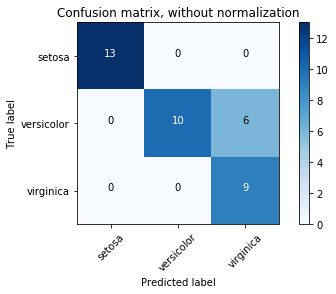

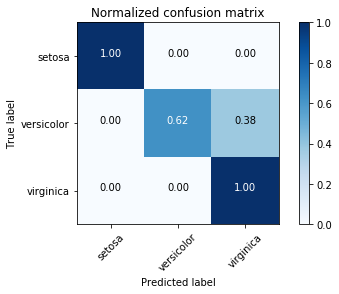

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


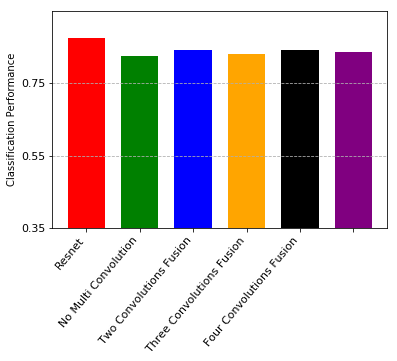

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(6)

# money = [81, 85, 83, 87,84]

auc = [90.1, 89.8, 88.7, 88.8,89.1,89.1]
sensitivity = [89.4, 91.1, 87.1, 88.2,94.1,89.1]

specificity = [80, 76.7, 82.2, 76.7,79.4,89.1]


accuracy = [0.875, 0.826, 0.842, 0.831,0.841,0.837]

# colors=['#FF0000']*5
# colors_x=['#008000']*5
# colors_y=['#0000FF']*5

colors = ['#FF0000', '#FF0000', '#FF0000', '#FF0000', '#FF0000','orange']
colors_x = ['#00FF00', '#00FF00', '#00FF00', '#00FF00', '#00FF00','']
colors_y = ['#0000FF', '#0000FF','#0000FF', '#0000FF', '#0000FF']


colors = ['red', 'green', 'blue', 'orange', 'black','purple']


fig, ax = plt.subplots()
# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.title('Effectiveness Of Fusing Avg-Pooling layer and Residual Block',fontsize=10,y=1.05)


ax.set_ylim(0.35,0.95)
plt.yticks([0.35,0.55,0.75],fontsize=11)
# plt.ylabel('Classification Accuracy(%)',y=0.5)
plt.ylabel('Classification Performance',y=0.5)



# a=plt.bar(x-0.25, auc,color=colors_x,width=0.25,tick_label=colors ,linewidth =0.5)
b=plt.bar(x, accuracy,color=colors,width=0.7,tick_label=colors ,linewidth =0.5)
# c=plt.bar(x+0.25, specificity,color=colors_y,width=0.25,tick_label=colors ,linewidth =0.5)

# plt.bar(x0.7, money,color=colors_x,width=0.7,tick_label=colors ,linewidth =0.5)
# plt.autoscale()

#roatation  means the lable rotate specific angles
ha = ['right', 'center', 'left']
plt.xticks(x, ('Resnet', 'No-Fusion', 'Concatenate-Fusion', 'Add-Fusion','Average-Fusion'),
           fontsize=11,
           rotation=50,ha=ha[0])

plt.xticks(x, ('Resnet', 'No Multi Convolution', 'Two Convolutions Fusion', 
               'Three Convolutions Fusion',
               'Four Convolutions Fusion'),
           fontsize=11,
           rotation=50,ha=ha[0])

plt.xticks(x, ('Resnet', 'No Multi Convolution', 'Two Convolutions Fusion', 
               'Three Convolutions Fusion',
               'Four Convolutions Fusion'),
           fontsize=11,
           rotation=50,ha=ha[0])



#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html
# plt.legend((a[0], b[0],c[0]), ('Sensitivity', 'AUC','Specificity'),loc="upper left", bbox_to_anchor=[0, 1],ncol=3)

# plt.grid(True)
plt.grid(axis='y',linestyle='--')
# ax.yaxis.grid(True,linestyle='--')
# plt.savefig('/home/ilab/Jupyter/Learing-CNN/Image/Multi_Convolution.png',
#             figsize=(50, 50), dpi=400,bbox_inches = 'tight')
plt.show()


# Drwa Scatter Pic


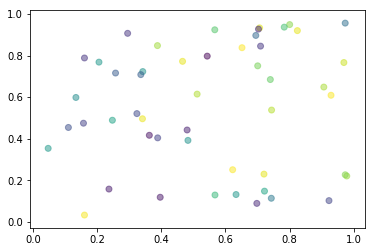

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)


N = 50
x = np.random.rand(N)
y = np.random.rand(N)
colors = np.random.rand(N)
area = np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii

# plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.scatter(x, y, c=colors, alpha=0.5)

plt.show()


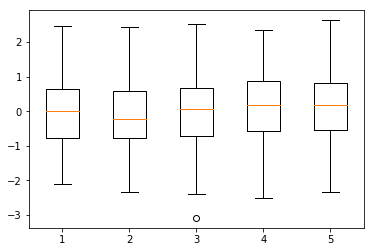

In [4]:
import numpy as np
import matplotlib.pyplot as plt
data = np.random.randn(100,5)
plt.boxplot(data)
plt.show()


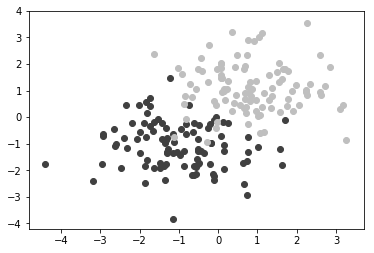

In [2]:
import numpy as np
import matplotlib.pyplot as plt
A = np.random.standard_normal((100, 2))
A += np.array((-1, -1)) # Center the distrib. at <-1, -1>
B = np.random.standard_normal((100, 2))
B += np.array((1, 1)) # Center the distrib. at <1, 1>
plt.scatter(A[:,0], A[:,1], color = '.25')
plt.scatter(B[:,0], B[:,1], color = '.75')
plt.show()

In [ ]:
import numpy as np                                                               
import matplotlib.pyplot as plt                                                                                                                                 

fig = plt.figure()                                                               
ax = fig.add_subplot(1,1,1)                                                      

# major ticks every 20, minor ticks every 5                                      
major_ticks = np.arange(0, 101, 20)                                              
minor_ticks = np.arange(0, 101, 5)                                               

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)                                           

# and a corresponding grid                                                       

ax.grid(which='both')                                                            

# or if you want differnet settings for the grids:                               
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.5)                                                

plt.show()